In [ ]:
import importlib
import terrain
import wind
import dynamics
import numpy as np
importlib.reload(terrain)
importlib.reload(wind)

<module 'wind' from '/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/wind.py'>

In [175]:
# Load terrain aspect dataset (pre-computed 1km)
terrain_ds = terrain.load_terrain_aspect_dataset()
terrain_ds

Loaded terrain aspect dataset: 232 x 772


<xarray.Dataset> Size: 6MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float64 2kB 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float64 6kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) float64 1MB ...
    aspect        (latitude, longitude) float64 1MB ...
    aspect_deg    (latitude, longitude) float64 1MB ...
    slope         (latitude, longitude) float64 1MB ...
    terrain_mask  (latitude, longitude) bool 179kB ...
Attributes:
    resolution_m:   990
    min_elevation:  500.0
    min_slope:      1.0
    description:    Terrain slope aspect dataset computed from SRTM data

In [ ]:
##Example usage to add terrain intersection to ERA5 data
import xarray as xr
terrain_ds = terrain.load_terrain_aspect_dataset()
era5_path = "./data/era5_example_dataset.nc"
era5_data = xr.open_dataset(era5_path)

# Crop ERA5 to terrain extent to reduce computation
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values
lat_min, lat_max = terrain_lats.min(), terrain_lats.max()
lon_min, lon_max = terrain_lons.min(), terrain_lons.max()

lat_min, lat_max = 47,48
lon_min, lon_max = 11,12

# Select ERA5 data within terrain bounds
era5_data = era5_data.sel(
    latitude=slice(lat_max, lat_min),  # ERA5 lats are decreasing
    longitude=slice(lon_min, lon_max)
)

terrain_ds = terrain_ds.sel(
    latitude=slice(lat_max, lat_min),  # ERA5 lats are decreasing
    longitude=slice(lon_min, lon_max)
)

# Interpolate ERA5 onto terrain grid
highres = False
if highres:
    era5_on_terrain = terrain.interpolate_to_grid(era5_data, terrain_ds)
    era5_with_terrain = terrain.compute_terrain_intersection(era5_on_terrain, terrain_ds)
else:
    era5_with_terrain = terrain.compute_terrain_intersection(era5_data, terrain_ds)

data = era5_with_terrain

## add geopotential height to ds
data['ghp'] = dynamics.geopotential_height(data['z'])

## add theta
data['theta'] = dynamics.potential_temperature(data['t'], data['pressure_level'])

Loaded terrain aspect dataset: 232 x 772
ERA5 domain: lat(47.0, 48.0), lon(11.0, 12.0)
Terrain elevation range on ERA5 grid: -32739m to 2884m

 Terrain intersection summary:
   925 hPa: mean height ~  856m,  2298/5929 ( 38.8%) below terrain
   850 hPa: mean height ~ 1546m,   737/5929 ( 12.4%) below terrain
   700 hPa: mean height ~ 3090m,     0/5929 (  0.0%) below terrain
   500 hPa: mean height ~ 5649m,     0/5929 (  0.0%) below terrain
   300 hPa: mean height ~ 9260m,     0/5929 (  0.0%) below terrain
ERA5 domain: lat(47.0, 48.0), lon(11.0, 12.0)
Terrain elevation range on ERA5 grid: -32739m to 2884m

 Terrain intersection summary:
   925 hPa: mean height ~  856m,  2298/5929 ( 38.8%) below terrain
   850 hPa: mean height ~ 1546m,   737/5929 ( 12.4%) below terrain
   700 hPa: mean height ~ 3090m,     0/5929 (  0.0%) below terrain
   500 hPa: mean height ~ 5649m,     0/5929 (  0.0%) below terrain
   300 hPa: mean height ~ 9260m,     0/5929 (  0.0%) below terrain


In [188]:
# Step 2: Add wind-terrain interaction
#era5_with_terrain['u'] = era5_with_terrain['u']*2.5
#era5_with_terrain['v'] = era5_with_terrain['v']*2.5
era5_enhanced = wind.compute_wind_terrain_interaction(era5_with_terrain, terrain_ds)
era5_enhanced

<xarray.Dataset> Size: 19MB
Dimensions:                   (valid_time: 10, pressure_level: 5, latitude: 77,
                               longitude: 77)
Coordinates:
  * valid_time                (valid_time) datetime64[ns] 80B 2025-10-01 ... ...
  * pressure_level            (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude                  (latitude) float64 616B 48.0 47.99 ... 47.03 47.01
  * longitude                 (longitude) float64 616B 11.01 11.02 ... 11.99
    number                    int64 8B 0
    expver                    (valid_time) <U4 160B '0005' '0005' ... '0005'
Data variables:
    z                         (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    u                         (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    v                         (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    terrain                   (valid_time, pressure_level, latitude, longitude) bool 296kB ...
    terrain_elevation         (latitude, longitude) float64 47kB 644.5 ... -7...
    geopotential_height       (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    perpendicular_wind_speed  (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    wind_speed                (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    wind_direction            (valid_time, pressure_level, latitude, longitude) float64 2MB ...
    downwind_terrain_height   (valid_time, pressure_level, latitude, longitude) float64 2MB ...

In [163]:
era5_enhanced['perpendicular_wind_speed']=era5_enhanced['perpendicular_wind_speed']*2

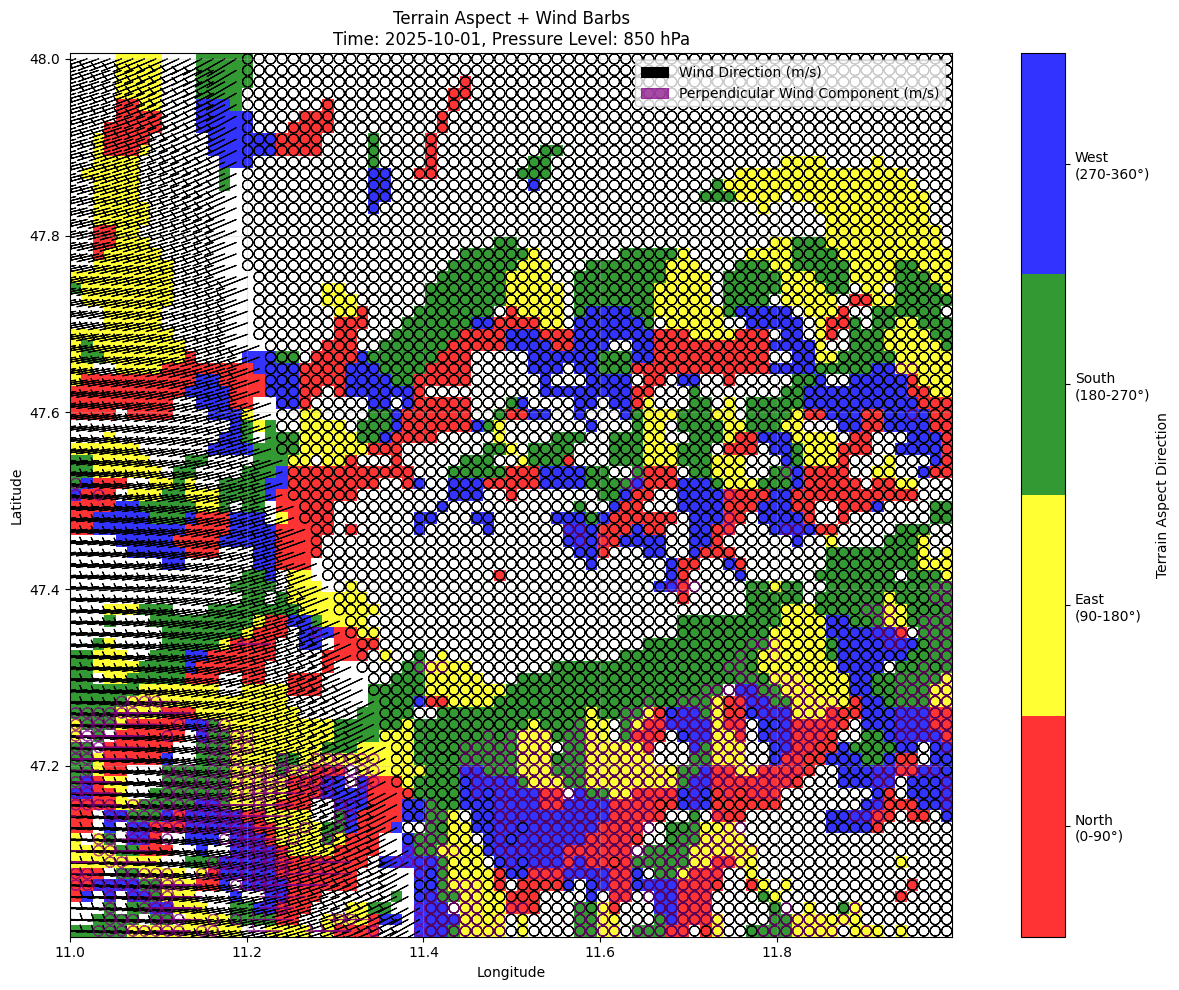

In [190]:
# Create visualization combining terrain aspect and wind vectors
# All data extracted from the datasets - completely self-contained
import matplotlib.pyplot as plt
# Get terrain data from terrain_ds
terrain_lats = terrain_ds.latitude.values
terrain_lons = terrain_ds.longitude.values
terrain_aspect = terrain_ds['aspect_deg'].values
terrain_mask = terrain_ds['terrain_mask'].values

# Get ERA5 data
era5_lats = era5_enhanced.latitude.values
era5_lons = era5_enhanced.longitude.values
time_steps = era5_enhanced.valid_time.values
pressure_levels = era5_enhanced.pressure_level.values

# Use first timestep and 850 hPa pressure level
time_idx = 0
plev = 850

# Extract wind data at specified time and pressure level
wind_direction = era5_enhanced['wind_direction'].sel(
    pressure_level=plev, 
    valid_time=time_steps[time_idx], 
    method='nearest'
).values  # in degrees

wind_speed = era5_enhanced['wind_speed'].sel(
    pressure_level=plev, 
    valid_time=time_steps[time_idx], 
    method='nearest'
).values  # wind speed in m/s

wind_perp = era5_enhanced['perpendicular_wind_speed'].sel(
    pressure_level=plev, 
    valid_time=time_steps[time_idx], 
    method='nearest'
).values  # perpendicular component in m/s

# Create figure and plot
fig, ax = plt.subplots(figsize=(14, 10))

# Plot 1: Terrain aspect with discrete colors (red, green, blue, yellow for 90-degree intervals)
aspect_categories = np.zeros_like(terrain_aspect)
aspect_categories[(terrain_aspect >= 0) & (terrain_aspect < 90)] = 0      # Red (N)
aspect_categories[(terrain_aspect >= 90) & (terrain_aspect < 180)] = 1    # Yellow (E)
aspect_categories[(terrain_aspect >= 180) & (terrain_aspect < 270)] = 2   # Green (S)
aspect_categories[(terrain_aspect >= 270) & (terrain_aspect < 360)] = 3   # Blue (W)

# Mask invalid terrain
aspect_display = np.ma.masked_where(terrain_mask == 0, aspect_categories)

# Custom colormap with 4 colors
colors = ['red', 'yellow', 'green', 'blue']
from matplotlib.colors import ListedColormap
cmap_aspect = ListedColormap(colors)

# Plot with discrete colormap
plot_aspect = True
if plot_aspect:
    im = ax.pcolormesh(terrain_lons, terrain_lats, aspect_display, 
                        cmap=cmap_aspect, vmin=-0.5, vmax=3.5, shading='auto', alpha=0.8)
    cbar = plt.colorbar(im, ax=ax, ticks=[0, 1, 2, 3])
    cbar.set_label('Terrain Aspect Direction')
    cbar.ax.set_yticklabels(['North\n(0-90°)', 'East\n(90-180°)', 'South\n(180-270°)', 'West\n(270-360°)'])

# Plot 2: Wind vectors as barbs on ERA5 grid
# Create mesh grid for all ERA5 points
lon_mesh, lat_mesh = np.meshgrid(era5_lons, era5_lats)

# Convert wind direction to U and V components
# Meteorological: 0=N, 90=E, 180=S, 270=W (where wind comes FROM)
wind_dir_rad = np.radians(wind_direction)
u_wind = wind_speed * np.sin(wind_dir_rad)
v_wind = wind_speed * np.cos(wind_dir_rad)

# Plot wind as barbs (black for direction)
ax.barbs(lon_mesh, lat_mesh, u_wind, v_wind, 
         color='black', length=7, linewidth=0.8, label='Wind Direction (m/s)')

# Plot perpendicular wind component as separate barbs in purple
# Plot the perpendicular wind magnitude directly from the dataset
ax.barbs(lon_mesh, lat_mesh, wind_perp, np.zeros_like(wind_perp), 
         color='purple', length=7, linewidth=0.8, alpha=0.7, label='Perpendicular Wind Component (m/s)')

# Labels and formatting
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
time_str = np.datetime_as_string(time_steps[time_idx], unit='D')
ax.set_title(f'Terrain Aspect + Wind Barbs\nTime: {time_str}, Pressure Level: {plev} hPa')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<xarray.Dataset> Size: 645MB
Dimensions:                   (valid_time: 10, pressure_level: 5,
                               latitude: 232, longitude: 772)
Coordinates:
  * valid_time                (valid_time) datetime64[ns] 80B 2025-10-01 ... ...
  * pressure_level            (pressure_level) float64 40B 925.0 850.0 ... 300.0
  * latitude                  (latitude) float64 2kB 48.0 47.99 ... 45.01 45.0
  * longitude                 (longitude) float64 6kB 6.0 6.013 ... 15.99 16.0
    number                    int64 8B 0
    expver                    (valid_time) <U4 160B '0005' '0005' ... '0005'
Data variables:
    z                         (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    u                         (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    v                         (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    terrain                   (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    geopotential_height       (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    perpendicular_wind_speed  (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    wind_speed                (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    wind_direction            (valid_time, pressure_level, latitude, longitude) float64 72MB ...
    downwind_terrain_height   (valid_time, pressure_level, latitude, longitude) float64 72MB ...

In [208]:
np.arange(0,len(era5_enhanced.pressure_level))
print(era5_enhanced.pressure_level[:])
print(era5_enhanced.pressure_level[1:])
zip(data.pressure_level, data.pressure_level[1:])

<xarray.DataArray 'pressure_level' (pressure_level: 5)> Size: 40B
array([925., 850., 700., 500., 300.])
Coordinates:
  * pressure_level  (pressure_level) float64 40B 925.0 850.0 700.0 500.0 300.0
    number          int64 8B 0
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure
<xarray.DataArray 'pressure_level' (pressure_level: 4)> Size: 32B
array([850., 700., 500., 300.])
Coordinates:
  * pressure_level  (pressure_level) float64 32B 850.0 700.0 500.0 300.0
    number          int64 8B 0
Attributes:
    long_name:         pressure
    units:             hPa
    positive:          down
    stored_direction:  decreasing
    standard_name:     air_pressure


In [ ]:
# Shift arrays along the pressure_level dimension
def compute_N_H(data):
    theta_up = data['theta'].shift(pressure_level=-1)
    theta_down = data['theta']
    z_up = data['z'].shift(pressure_level=-1)
    z_down = data['z']
    U_up = data['perpendicular_wind_speed'].shift(pressure_level=-1)
    U_down = data['perpendicular_wind_speed']

    # Calculate N and H
    N = brunt_vaisala_freq(theta_up, theta_down, z_up, z_down)
    H = nondim_mtn_height(N, z_up - z_down, U_up, U_down)

    # Remove the last level (which has NaNs because of shift)
    N = N.isel(pressure_level=slice(0, -1))
    H = H.isel(pressure_level=slice(0, -1))

    data = data.assign(N=N, H=H)
    return data